In [1]:
import numpy as np 
import pandas as pd 
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.onnx

# device = (
#     "cuda" if torch.cuda.is_available() else "cpu"
# )
device = (
    "cpu"
)
print(torch.__version__)


print(device)

2.6.0+cu118
cpu


## 通用方法

### 数据图像

In [2]:
titles = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

def show_images(imgs, num_rows, num_cols, labels=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if labels:
            ax.set_title(titles[labels[i]])
    return axes

def show_loss(
    train_losses: list[float], test_losses: list[float], test_accs: list[float]
):
    """绘制loss图形"""
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, "r-", label="train_losses")
    plt.plot(test_losses, "b-", label="test_losses")
    plt.plot(test_accs, "g-", label="test_accs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

### 模型训练和测试

In [3]:

def train(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cpu",
    epochs: int = 1,
    model_name: str = "mnist_fashion"  
):
    # 训练损失
    train_losses = []
    # 测试损失
    test_losses = []
    # 测试准确率
    test_accs = []
    model.to(device)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        test_loss, correct = test(model, test_loader, loss_fn, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(correct)
    print("Done!")

    show_loss(train_losses, test_losses, test_accs)
    
    # 保存模型
   
    torch.save(model, f"./model/{model_name}.pth")  # 保存完整模型
    print(f"Model saved in ./model/ as {model_name}.pth")
    
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cpu",
):
    model.train()  # 设置模型为训练模式

    batch_nums = len(dataloader)  # 批次数
    batch_size = dataloader.batch_size  # 批量大小
    size = len(dataloader.dataset)  # 数据集大小
    train_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss: torch.Tensor = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % int(batch_nums / 10) == 0:
            loss, current = loss.item(), (batch + 1) * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # 计算训练集的平均损失
    train_loss /= batch_nums
    print(f"train avg loss: {train_loss}")
    return train_loss


def test(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: str = "cpu",
):
    """测试
    Args:
        model (torch.nn.Module): 模型
        dataloader (torch.utils.data.DataLoader): 数据加载器
        loss_fn (torch.nn.Module): 损失函数
        device (str, optional): 设备. Defaults to "cpu".
    """
    model.eval()  # 设置模型为评估模式

    batch_nums = len(dataloader)  # 批次数
    size = len(dataloader.dataset)  # 数据集大小
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss: torch.Tensor = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= batch_nums
    correct /= size
    print(f"Test Accuracy: {(100*correct):>0.1f}%, Test Avg loss: {test_loss:>8f}")
    print("--------------------------------")

    return test_loss, correct

## 数据加载

如果使用VGG卷积训练需要加一步：设置图片大小为（244,244），如果是Softmax的话使用原本的（28,28）就行 本次使用Softmax

In [4]:
train_df = pd.read_csv('./input/fashion-mnist_train.csv')
test_df = pd.read_csv('./input/fashion-mnist_test.csv')

# 提取标签列
train_labels = train_df.iloc[:, 0].values
test_labels = test_df.iloc[:, 0].values

# 提取像素值并归一化到 [0,1] 区间
train_images = train_df.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
test_images = test_df.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

# 转换为 PyTorch 张量
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# 构建DataLoader
batch_size = 64

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### 数据预览

torch.Size([64, 1, 28, 28]) torch.Size([64])
X[0] shape: torch.Size([1, 28, 28])
y[0] shape: tensor(4)


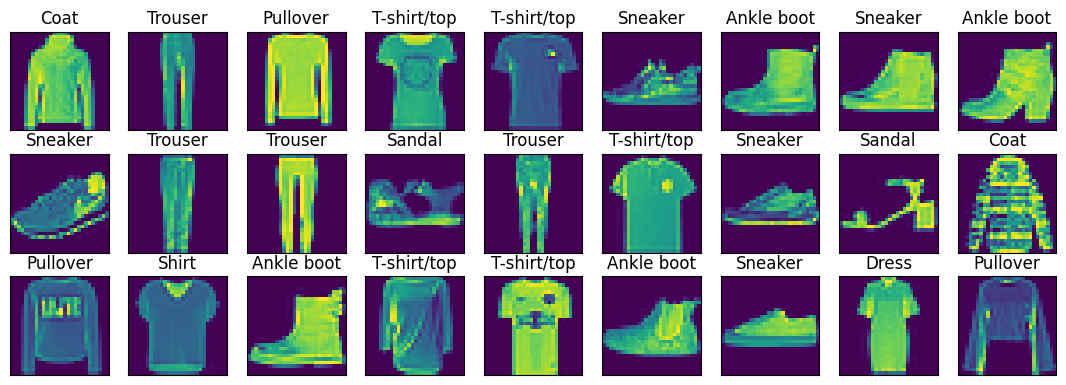

In [5]:

for X, y in train_loader:
    print(X.shape,y.shape)
    # print("数据示例:", X[0])  
    # print("标签示例:", y[0])  
    
    print("X[0] shape:", X[0].shape)  
    print("y[0] shape:", y[0])
    
    # print("标签示例:", y[0])  # 输出对应的标签示例
    show_images(X.reshape(batch_size, 28, 28), 3, 9,labels=y.tolist())
    break  # 只输出一个示例

## 使用Softmax训练

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.384586  [   64/60000]
loss: 1.303180  [ 6016/60000]
loss: 1.019649  [11968/60000]
loss: 1.074777  [17920/60000]
loss: 0.904440  [23872/60000]
loss: 0.787639  [29824/60000]
loss: 0.854744  [35776/60000]
loss: 0.901839  [41728/60000]
loss: 0.798950  [47680/60000]
loss: 0.647379  [53632/60000]
loss: 0.742353  [59584/60000]
train avg loss: 0.9669928089387889
Test Accuracy: 77.1%, Test Avg loss: 0.730685
--------------------------------
Epoch 2
-------------------------------
loss: 0.736449  [   64/60000]
loss: 0.650238  [ 6016/60000]
loss: 0.829358  [11968/60000]
loss: 0.546356  [17920/60000]
loss: 0.625078  [23872/60000]
loss: 0.652197  [29824/60000]
loss: 0.684409  [35776/60000]
loss: 0.609652  [41728/60000]
loss: 0.645068  [47680/60000]
loss: 0.677062  [53632/60000]
loss: 0.479418  [59584/60000]
train avg loss: 0.670543371391957

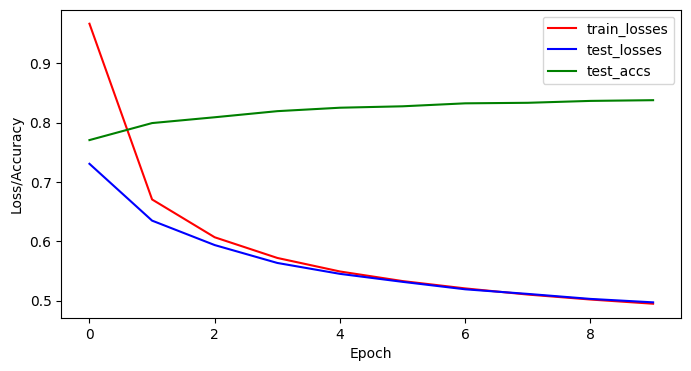

Model saved in ./model/ as mnist_fashion_weights.pth and mnist_fashion.pth


In [6]:
# 1. Softmax回归
epochs ,lr= 10,0.01

net = nn.Sequential(nn.Flatten(),nn.Linear(28 * 28, 10))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr)

print(net)

train(net,train_loader,test_loader,loss_fn,optimizer,epochs=epochs,device=device)

## 使用VGG卷积训练

**由于在本次Coursework使用的PYNQ Z1配置下（armv7l架构，ubuntu22.04, python3.10），onnxruntime和torchvision的wheel文件太难找，所以不使用该方法，想学习的可以在PC上试试** (绝对不是我学不明白VGG卷积Q_Q)

In [7]:
# 卷积 - VGG
def vgg_block(num_convs,in_channels,out_channels):
    """VGG块
    Args:
        num_convs (int): 卷积层数量
        in_channels (int): 输入通道数
        out_channels (int): 输出通道数
    """
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, epochs, batch_size = 0.05, 10, 128

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr)

train(net,train_loader_224,test_loader_224,loss_fn,optimizer,epochs=epochs,device=device)

NameError: name 'train_loader_224' is not defined

### 将VGG训练的模型输出为轻量化ONNX模型

这里的dummy_input需要与训练的图片大小对应：（244,244），并且在pynq上推理时也要处理图片大小为（244,244）
但不知道为什么resize后推理精度很差，所有的都识别成Sandal。反正已经舍弃这一种方法了，就允许我摆一下吧

In [34]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 10)
)
model = torch.load("./output/mnist_fashion.pth", map_location='cpu', weights_only=False)
model.to('cpu')  # 确保模型在CPU上
model.eval()

dummy_input = torch.randn(1, 1, 224, 224).to('cpu')

# 导出ONNX
torch.onnx.export(
    model,
    dummy_input,
    "./model/mnist_fashion.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    }
)
print("ONNX exported successfully")

ONNX exported successfully
